<a href="https://colab.research.google.com/github/SaadIqbalGH/Deep-Learning-Basic-ANN-/blob/main/Flowers%20Recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Assignment: Flowers Recognition**
Dataset Description:

This dataset contains 4242 images of flowers.
The data collection is based on the data flicr, google images, yandex images.
You can use this datastet to recognize plants from the photo.

Attribute Information:
The pictures are divided into five classes: chamomile, tulip, rose, sunflower, dandelion.
For each class there are about 800 photos. Photos are not high resolution, about 320x240 pixels.
**Also explore how to resize images in tensorflow and then resize all the images to a same size.**
This is a Multiclass Classification Problem.

### **WORKFLOW :**
Load Data
Split into 60 and 40 ratio.  
Encode labels.  
Create Model  
Compilation Step (Note : Its a Multiclass Classification problem , select loss , metrics according to it)  
Train the Model.  
If the model gets overfit tune your model by changing the units , No. of layers , epochs , add dropout layer or add Regularizer according to the need .  
Prediction should be > 85%  
Evaluation Step  
Prediction  

**Data :**  
https://drive.google.com/file/d/1-OX6wn5gA-bJpjPNfSyaYQLz-A-AB_uj/view?usp=sharing

In [98]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import os
import PIL
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [99]:
tf.__version__

'2.4.1'

In [100]:
import pathlib
data_dir = pathlib.Path('/content/drive/MyDrive/Colab Notebooks/flowers')

In [101]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

4323


In [106]:
batch_size = 32
img_height = 180
img_width = 180

In [107]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.4,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 4323 files belonging to 5 classes.
Using 2594 files for training.


In [108]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.4,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 4323 files belonging to 5 classes.
Using 1729 files for validation.


In [109]:
class_names = train_ds.class_names
print(class_names)

['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']


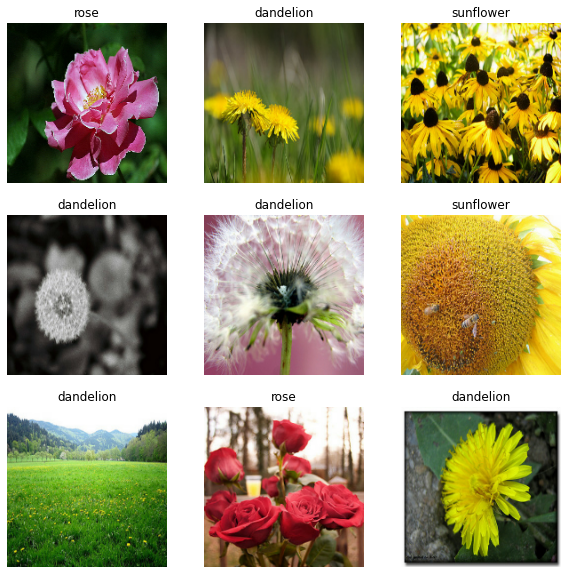

In [110]:
#  first 9 images from the training dataset.
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [111]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


In [112]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [113]:
data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal", 
                                                 input_shape=(img_height, 
                                                              img_width,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)

In [114]:
num_classes = 5
model = Sequential([
  data_augmentation,
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [115]:
model.summary()

Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_19 (Sequential)   (None, 180, 180, 3)       0         
_________________________________________________________________
rescaling_8 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d_24 (MaxPooling (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_25 (MaxPooling (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 45, 45, 64)      

In [116]:
import time
start = time.time()
epochs = 15
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  verbose=0
)
end = time.time()
duration = end - start
print ('\n model_scratch took %0.2f seconds (%0.1f minutes) to train for %d epochs'%(duration, duration/60, epochs) )


 model_scratch took 73.02 seconds (1.2 minutes) to train for 15 epochs


In [118]:
sunflower_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/592px-Red_sunflower.jpg"
sunflower_path = tf.keras.utils.get_file('Red_sunflower', origin=sunflower_url)

img = keras.preprocessing.image.load_img(
    sunflower_path, target_size=(img_height, img_width)
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

This image most likely belongs to sunflower with a 99.92 percent confidence.


In [119]:
model.save('model.h5')